In [1]:
import pandas as pd
from matplotlib import pyplot as plt

After importing the necessary libraries, we read the wide format of the csv file into a Pandas DataFrame we created called "df_w". Then, we converted "timestamp" column, which is an object column to datetime format by using pd.to_datetime() function. Lastly, we sorted the rows of df_w according the "timestamp" column in ascending order. 

In [2]:
df_w = pd.read_csv("all_ticks_wide.csv")
df_w["timestamp"] = pd.to_datetime(df_w["timestamp"])
df_w = df_w.sort_values(by="timestamp")

Then, we created a function called Find_Outliers() which returns the outliers of a given dataframe. The function takes a dataframe of two columns as input, one being the "timestamp" and other being the column we want to find outliers of, finds the outliers for the second column by first calculating the mean and standart deviation, then creating the lower and upper 3-sigma limits by a simple formula, then iterating through the second column of the dataframe to find values that are higher than the upper limit or lower than the lower limit, lastly, it returns a dictionary called "outliers" which includes both lower and higher outliers. 

In [3]:
def Find_Outliers(df):
        mean = df.iloc[:,1].mean()
        std = df.iloc[:,1].std()
        upper_limit = mean + 3*std
        lower_limit = mean - 3*std
        lower_outliers = df[df.iloc[:,1] < lower_limit]
        higher_outliers = df[df.iloc[:,1] > upper_limit]
        outliers = {"lower_outliers" : lower_outliers, "higher_outliers" : higher_outliers }
        
        return outliers

Since we need to calculate the monthly outliers, we had to divide df_w into monthly dataframes. So, we created a new function called "Monthly_Data" which takes a dataframe, and a tuple key that indicates the exact year and month of that dataframe is needed as input, and returns the new dataframe. For instance, when the function is called as Monthly_Data(df = df_w, key = (2017,3)), it will return a new dataframe consisting of all the columns in df_w in 3rd month of 2017.

In [4]:
def Monthly_Data(df, key):
    df_Monthly_dictionary = {}
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df_yearly = df["timestamp"].dt.year
    for i in range(2012,2020):
        df_current_year = df.loc[df_yearly == i]
        df_current_year_monthly = df_current_year["timestamp"].dt.month
        for k in range(1,13):
             df_Monthly_dictionary[i,k] = df_current_year.loc[df_current_year_monthly == k]
    
    return df_Monthly_dictionary.get(key)

Next, we created the function Find_Outliers_Column_Month() which combines the functions Find_Outliers() and Monthly_Data(). Given the inputs that are a dataframe, column_name, and a key, Find_Outliers_Column_Month() returns a dictionary consisting of all the outliers of the given stock in that certain year and month. For example, when the function is called as Find_Outliers_Column_Month(df = df_w, column_name = "CEMAS", key = (2016, 5)), it returns the outliers of the stock data of CEMAS in the 5th month of 2016.

As our given data had several null values, we interpolated them by the Pandas DataFrame.interpolate() function. This function fills the null values by taking the average of values before and after the null value.

In [8]:
def Find_Outliers_Column_Month(df,column_name,key):
    df_column = df.loc[:,["timestamp",column_name]]
    df_column_without_null = df_column.interpolate()
    df_column_monthly = Monthly_Data(df_column_without_null, key)
    return Find_Outliers(df_column_monthly)

# Find_Outliers_Column_Month(df_w,column_name = "CEMAS", key = (2017,2))

{'lower_outliers': Empty DataFrame
 Columns: [timestamp, CEMAS]
 Index: [],
 'higher_outliers':                       timestamp  CEMAS
 30467 2017-02-02 06:45:00+00:00   1.73}

Lastly, we created the function Create_Graph that takes a dataframe, column_name, and a key as input, and creates a line graph of the given stock at the given year and month. For instance, if the function is called as Create_Graph(df_w,column_name = "YATAS", key = (2017,9)), it draws a line graph in which has the values of CEMAS in 9th month of 2017 on y-axis, and "timestamp" on the x-axis. We also added three dotted lines on each graph, the green one representing the mean of the values, and the red ones representing the 3-sigma limits. 

In [6]:
def Create_Graph(df,column_name,key):
    df_column = df.loc[:,["timestamp",column_name]]
    df_column_without_null = df_column.interpolate()
    df_column_monthly = Monthly_Data(df_column_without_null, key)
    plt.plot_date(df_column_monthly["timestamp"], df_column_monthly[column_name],fmt=",-")
    plt.gcf().autofmt_xdate()
    plt.axhline(y = df_column_monthly[column_name].mean(), color = 'g', linestyle = '--')
    plt.axhline(y = df_column_monthly[column_name].mean() + 3*df_column_monthly[column_name].std(), color = 'r', linestyle = '--')
    plt.axhline(y = df_column_monthly[column_name].mean() - 3*df_column_monthly[column_name].std(), color = 'r', linestyle = '--')
    plt.xlabel("Timestamp")
    plt.ylabel(column_name) 

#Create_Graph(df_w,column_name = "CEMAS", key = (2018,3))

In [7]:
def Create_Multiple_Graphs(df,column_name, year):
    df_column = df.loc[:,["timestamp",column_name]]
    df_column_without_null = df_column.interpolate()
    
    fig, ax_array = plt.subplots(nrows=3, ncols=4, figsize=(20, 16))
    
    i = 1
   
    for ax in ax_array.flatten():
        key = (year,i)
        df_column_monthly = Monthly_Data(df_column_without_null, key)
        ax.plot_date(df_column_monthly["timestamp"], df_column_monthly[column_name],fmt=",-")
        
        ax.axhline(y = df_column_monthly[column_name].mean(), color = 'g', linestyle = '--')
        ax.axhline(y = df_column_monthly[column_name].mean() + 3*df_column_monthly[column_name].std(), color = 'r', linestyle = '--')
        ax.axhline(y = df_column_monthly[column_name].mean() - 3*df_column_monthly[column_name].std(), color = 'r', linestyle = '--')
        
        ax.set_xlabel("Timestamp")
        ax.set_ylabel(column_name)
        
        ax.set_xticks(ax.get_xticks())  
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')  

        i = i + 1
    

#Create_Multiple_Graphs(df_w,column_name = "CEMAS", year = 2017)

# ANALYSIS OF STOCK PRICES
We analyzed PETKM, EREGL and FROTO shares over a 25-month period from June 2017 to July 2019. With the functions we introduced above, we specifically investigated the dates when the share values took outlier values and tried to identify the reasons. In addition, we also analyzed the Google Trends data associated with the shares and tried to show the parallels with the share values.

## PETKM
Petkim is a leading petrochemical company in Turkey that produces a wide range of basic petrochemical products. Established in 1965, it supplies raw materials for various industries, including plastics, detergents, textiles, construction, automotive, electronics, packaging, paint, cosmetics, and agriculture. Its product line includes polyethylene, polypropylene, PVC (polyvinyl chloride), raw materials for detergents, various solvents, and other chemical substances. Petkim operates Turkey's first and only integrated petrochemical complex located in Aliağa, Izmir, and markets its products domestically and internationally.

16.08.2017

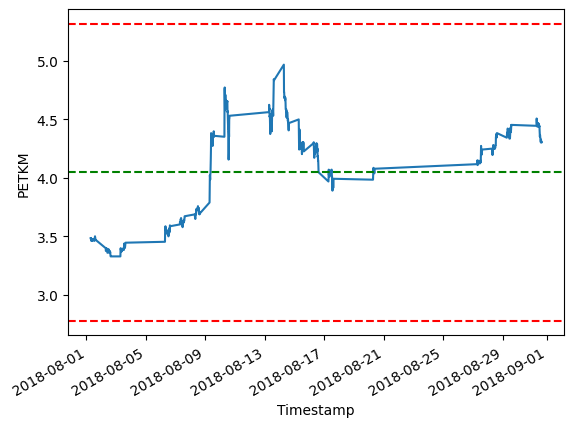

On the same day that the share price fell, news broke that the Petrol-Is Union demanded the reinstatement of dismissed employees at Petkim. Stating that the attitudes and behavior of some Petkim executives should be reviewed, the union said that it was unlawful to dismiss without just cause. The fact that the company was subjected to such criticism by the union must have lowered its reputation in the eyes of the public, which in turn lowered its share prices.
[https://uzmanpara.milliyet.com.tr/raporlar-analizler/petrol-is-sendikasi--petkimde-is-akitleri-fesh-edilenlerin-ise-iadesini-talep-etti/926460/]
